## Imports and Basic Functions

In [1]:
import json
import pandas as pd
import scipy.stats
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.transforms import ScaledTranslation

In [2]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'figure.facecolor': (0,0,0,0), 'savefig.transparent': True}, palette='colorblind')

In [3]:
def load_json(json_filename):
    with open(json_filename) as f_in:
        ret_dict = json.load(f_in)
        subjects = set(ret_dict.keys())

    return ret_dict, subjects

In [4]:
def get_pred(question_dict):
    pred = ''
    pred_prob = 0
    for let, let_res in question_dict['results'].items():
        if let_res['agg_prob'] > pred_prob:
            pred = let
            pred_prob = let_res['agg_prob']

    return pred

In [5]:
# Load data

file_no_cot       = './results_data/LLaMa3.1-8B_no_cot_all_results.json'
file_cot_unprimed = './results_data/LLaMa3.1-8B_cf_cot_all_results.json'
file_cot_primed   = './results_data/LLaMa3.1-8B_apricot_all_results.json'

file_cloze_br = ''

choice_map = {'A':0, 'B':1, 'C':2, 'D':3}

all_exp_sets = [file_no_cot, file_cot_unprimed, file_cot_primed]
all_exp_labels = ['no_cot', 'unprimed_cot', 'primed_cot']

no_cot_res, subjects = load_json(file_no_cot)
unprimed_res, _ = load_json(file_cot_unprimed)
primed_res, _ = load_json(file_cot_primed)

## Base-Rate Probability

In [6]:
def base_rate_analysis(br_file):
    with open(br_file) as f_in:
        res = json.load(f_in)
    probs    = {'A': [], 'B': [], 'C': [], 'D': []}
    for ordering, ord_results in res['base_rate'].items():
        for let, let_results in ord_results['results'].items():
            probs[let].append(let_results['agg_prob'])
            
    fig, ax = plt.subplots()

    reshaped = {'Choice': [], 'Probability': []}
    for k, v in probs.items():
        for p in v:
            reshaped['Choice'].append(k)
            reshaped['Probability'].append(p)
    probs_df = pd.DataFrame(reshaped)
    sns.boxplot(probs_df, x='Choice', y='Probability', hue='Choice', ax=ax)

    agg_br = [np.mean(probs[k]) for k in 'ABCD']
    agg_br_df = pd.DataFrame({'Choice': ['A', 'B', 'C', 'D'], 'Probability': agg_br})
    sns.scatterplot(agg_br_df, x='Choice', y='Probability', hue='Choice', ax=ax, marker='*', s=150, zorder=2, edgecolors='black', legend=False)

    plt.title('Relative Base Rate Probability\n(Across Orderings)', size=20)
    ax.set_ylabel('Probability',size=18)
    ax.set_xlabel('Answer Choice',size=18)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.ticklabel_format(axis="y", style='plain')
    plt.tight_layout()
    plt.show()

    return agg_br

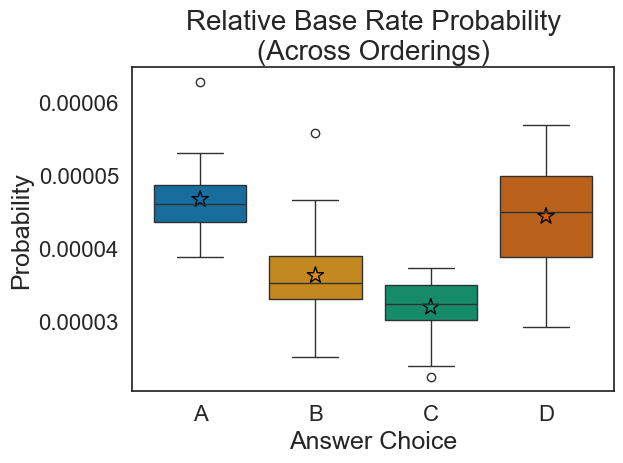

A: 4.671340860765865e-05
B: 3.628404908800412e-05
C: 3.193435995352197e-05
D: 4.4386739950189905e-05


In [7]:
agg_br_cloze = base_rate_analysis('./results_data/LLaMa3.1-8B_cloze_br_results.json') 
print('A: {}\nB: {}\nC: {}\nD: {}'.format(*agg_br_cloze))


## Answer Distributions. Raw + correlation with BRP

In [8]:
def ans_dists_per_sub(): 
    no_cot_dists   = {}
    unprimed_dists = {}
    primed_dists   = {}
    gt_dists       = {}

    for sub in subjects:
        if sub == 'base_rate':
            continue

        no_cot_dists[sub] =   [0, 0, 0, 0]
        unprimed_dists[sub] = [0, 0, 0, 0]
        primed_dists[sub] =   [0, 0, 0, 0]
        gt_dists[sub] =       [0, 0, 0, 0]

        for k in no_cot_res[sub].keys():
            no_cot_pred = get_pred(no_cot_res[sub][k])
            no_cot_dists[sub][choice_map[no_cot_pred]] += 1 

            unprimed_pred = get_pred(unprimed_res[sub][k])
            unprimed_dists[sub][choice_map[unprimed_pred]] += 1 

            primed_pred = get_pred(primed_res[sub][k]) 
            primed_dists[sub][choice_map[primed_pred]] += 1 

            gt_dists[sub][choice_map[primed_res[sub][k]['correct_answer']]] += 1

    return no_cot_dists, unprimed_dists, primed_dists, gt_dists

In [8]:
def ans_dists(raw=True, plot=True, return_res=True):
    no_cot_dist   = [0,0,0,0]
    unprimed_dist = [0,0,0,0]
    primed_dist   = [0,0,0,0]
    correct_dist  = [0,0,0,0]

    for sub in subjects:
        if sub == 'base_rate':
            continue
        
        for k in no_cot_res[sub].keys():
            no_cot_pred = get_pred(no_cot_res[sub][k])
            no_cot_dist[choice_map[no_cot_pred]] += 1 

            unprimed_pred = get_pred(unprimed_res[sub][k])
            unprimed_dist[choice_map[unprimed_pred]] += 1 

            primed_pred = get_pred(primed_res[sub][k])
            primed_dist[choice_map[primed_pred]] += 1 

            correct_dist[choice_map[no_cot_res[sub][k]['correct_answer']]] += 1

    if not (sum(no_cot_dist) == sum(unprimed_dist) == sum(primed_dist) == sum(correct_dist)):
        raise Exception('Questions dropped')
    
    if not raw:
        total = sum(no_cot_dist)

        no_cot_dist = [i / total for i in no_cot_dist]
        unprimed_dist = [i / total for i in unprimed_dist]
        primed_dist = [i / total for i in primed_dist]
        correct_dist = [i / total for i in correct_dist]

    if plot:
        annot_kws = {
            'fontsize' : 'xx-large',
            'fontweight' : 'heavy'
        }

        ax = sns.heatmap([no_cot_dist, unprimed_dist, primed_dist, correct_dist],
                        xticklabels=['A','B','C','D'],
                        yticklabels=['No CoT', 'CoT', 'APriCoT', 'Ground Truth'],
                        cmap='viridis',
                        annot=True,
                        fmt='' if raw else '.2%',
                        annot_kws=annot_kws)

        ax.set_xlabel('Answer Choice Distribution')

        plt.tight_layout()
        plt.show()

    if return_res:
        return no_cot_dist, unprimed_dist, primed_dist, correct_dist


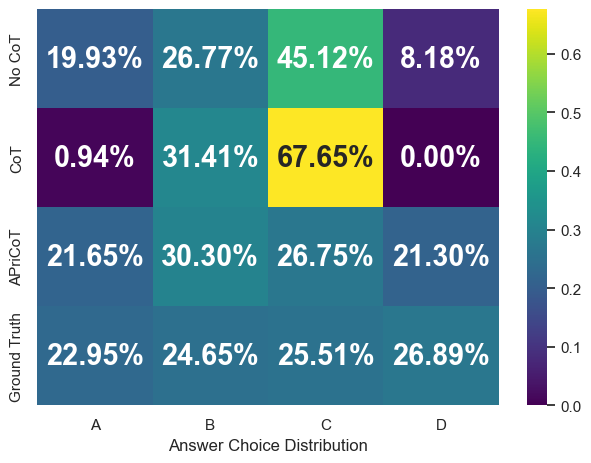

In [9]:
ans_dists(False, True, False)

In [10]:
def ridge_plot_ans_dist():
    no_cot_dist, unprimed_dist, primed_dist, correct_dist = ans_dists(plot=False)

    dist_dict = {'CoT Type': [], 'Choice': []}

    cot_labels = [
        'CoT',
        'No CoT',
        'APriCoT',
        'Ground Truth',
        ]
    cot_dists = [
        unprimed_dist,
        no_cot_dist,
        primed_dist,
        correct_dist,
        ]
    cot_dict = {
        1:
            'CF+CoT',
        2:
            'CF', 
        3:
            'APriCoT',
        4:
            'Ground Truth',
    }

    for cot_type, dist in zip(cot_labels, cot_dists):
        for choice, count in zip([1,2,3,4], dist):
            dist_dict['CoT Type'] += [cot_type] * count
            dist_dict['Choice'] += [choice] * count
    
    g = sns.FacetGrid(pd.DataFrame(dist_dict), row='CoT Type', hue='CoT Type', aspect=5, height=1) 
    g.map(sns.kdeplot, 'Choice',
        bw_adjust=1, clip_on=False,
        fill=True, alpha=1, linewidth=1.5)
    g.map(sns.kdeplot, 'Choice', 
        bw_adjust=1, clip_on=False, 
        color="w", lw=0.5, )
    g.map(plt.axhline, y=0,
        lw=2, clip_on=False)
    
    for i, ax in enumerate(g.axes.flat):
        ax.text(0.5, 0.04, cot_dict[i+1],
                fontweight='bold', fontsize=15,
                color=ax.lines[-1].get_color(),
                ha='right')
        
    g.fig.subplots_adjust(hspace=-0.85)

    g.set_titles("")
    g.set(yticks=[])
    g.set(xticks=[1,2,3,4])
    g.despine(bottom=True, left=True)
    g.set_ylabels('')
    g.set_xticklabels(['A', 'B', 'C', 'D'])

    plt.setp(ax.get_xticklabels(), fontsize=15, fontweight='bold')
    plt.xlabel('Answer Choice Distribution', fontweight='bold', fontsize=15)
    g.fig.suptitle('Answer Choice Distribution\n(per CoT method + ground truth)',
                   ha='center',
                   fontsize=20,
                   fontweight='bold',
                   y=1.03)

    plt.show()

In [12]:
def per_ans_acc(data, sort_probs=False):
    results = []
    total = [0, 0, 0, 0]
    total_n = [0,0,0,0]
    for sub in subjects:
        sub_res = [0,0,0,0]
        sub_n = [0,0,0,0]
        for k in data[sub].keys():
            corr = data[sub][k]['correct_answer']
            pred = get_pred(data[sub][k])

            if corr == pred:
                sub_res[choice_map[corr]] += 1
                total[choice_map[corr]] += 1
            sub_n[choice_map[corr]] += 1
            total_n[choice_map[corr]] += 1
        sub_res = [r / n for r, n in zip(sub_res, sub_n)]
        results.append((sub, sub_res))
    total = [r / n for r, n in zip(total, total_n)]

    results.append(('#TOTAL', total))

    results = list(sorted(results, key=lambda x: x[1 if sort_probs else 0]))

    return results

In [13]:
def correlation_wilcoxon(agg_br):
    results_agg = {'CoT Type': [], 'Correlation': [], 'Subject': []}
    totals = {}

    corr_func = scipy.stats.pearsonr

    ds_arr = [ds for ds in ans_dists_per_sub()]
    ds_labs = ['No CoT', 'CoT', 'APriCoT', 'Ground Truth']
    for ds, lab in zip(ds_arr, ds_labs):
        totals[lab] = [0,0,0,0]
        for sub, sub_dist in ds.items():
            results_agg['CoT Type'].append(lab)
            results_agg['Subject'].append(sub)
            results_agg['Correlation'].append(corr_func(agg_br, sub_dist).statistic)

            for i in range(4):
                totals[lab][i] += sub_dist[i]
        else:
            results_agg['CoT Type'].append(lab)
            results_agg['Subject'].append(' Total')
            results_agg['Correlation'].append(corr_func(agg_br, totals[lab]).statistic)

    subs_df = pd.DataFrame(results_agg)

    subs_df.sort_values(by='Subject', ascending=True, inplace=True)
    temp1 = subs_df[subs_df['CoT Type']=='Ground Truth']['Correlation']
    temp2 = subs_df[subs_df['CoT Type']=='APriCoT']['Correlation']
    print('APriCoT:', scipy.stats.wilcoxon(temp1.to_list(), temp2.to_list()))
    temp2 = subs_df[subs_df['CoT Type']=='CoT']['Correlation']
    print('CF+CoT: ', scipy.stats.wilcoxon(temp1.to_list(), temp2.to_list()))
    temp2 = subs_df[subs_df['CoT Type']=='No CoT']['Correlation']
    print('No CoT: ', scipy.stats.wilcoxon(temp1.to_list(), temp2.to_list()))

correlation_wilcoxon(agg_br_cloze)

APriCoT: WilcoxonResult(statistic=521.0, pvalue=0.009602741017285685)
CF+CoT:  WilcoxonResult(statistic=15.0, pvalue=7.644049396171772e-11)
No CoT:  WilcoxonResult(statistic=218.0, pvalue=7.984462198712778e-07)


In [14]:
def br_dist_corr_lines(agg_br, spearman=True, total_line=True, fishersz=False):
    def alt_bands(ax=None, highlight = None):
        ax = ax or plt.gca()
        x_left, x_right = ax.get_xlim()
        locs = ax.get_xticks()
        count = 0
        for loc1, loc2 in zip(locs[::2], np.concatenate((locs, [x_right]))[1::2]):
            if count == highlight:
                ax.axvspan(loc1-0.5, loc1+0.5, facecolor='yellow', alpha=0.2)
            else:
                ax.axvspan(loc1-0.5, loc1+0.5, facecolor='gray', alpha=0.2)
            count += 1
        ax.set_xlim(x_left, x_right)

    subject_name_map ={
        'abstract_algebra' : 'Abstract Algebra',
        'anatomy' : 'Anatomy',
        'astronomy' : 'Astronomy',
        'business_ethics' : 'Business Ethics',
        'clinical_knowledge' : 'Clinical Knowledge',
        'college_biology' : 'College Biology',
        'college_chemistry' : 'College Chemistry',
        'college_computer_science' : 'College CS',
        'college_mathematics' : 'College Math',
        'college_medicine' : 'College Medicine',
        'college_physics' : 'College Physics',
        'computer_security' : 'Computer Security',
        'conceptual_physics' : 'Conceptual Physics',
        'econometrics' : 'Econometrics',
        'electrical_engineering' : 'Electrical Engineering',
        'elementary_mathematics' : 'Elementary Math',
        'formal_logic' : 'Formal Logic',
        'global_facts' : 'Global Facts',
        'high_school_biology' : 'HS Biology',
        'high_school_chemistry' : 'HS Chemistry',
        'high_school_computer_science' : 'HS Computer Science',
        'high_school_european_history' : 'HS European History',
        'high_school_geography' : 'HS Geography',
        'high_school_government_and_politics' : 'HS Gov. and Politics',
        'high_school_macroeconomics' : 'HS Macroeconomics',
        'high_school_mathematics' : 'HS Math',
        'high_school_microeconomics' : 'HS Microeconomics',
        'high_school_physics' : 'HS Physics',
        'high_school_psychology' : 'HS Psychology',
        'high_school_statistics' : 'HS Statistics',
        'high_school_us_history' : 'HS US History',
        'high_school_world_history' : 'HS World History',
        'human_aging' : 'Human Aging',
        'human_sexuality' : 'Human Sexuality',
        'international_law' : 'International Law',
        'jurisprudence' : 'Jurisprudence',
        'logical_fallacies' : 'Logical Fallacies',
        'machine_learning' : 'Machine Learning',
        'management' : 'Management',
        'marketing' : 'Marketing',
        'medical_genetics' : 'Medical Genetics',
        'miscellaneous' : 'Misc.',
        'moral_disputes' : 'Moral Disputes',
        'moral_scenarios' : 'Moral Scenarios',
        'nutrition' : 'Nutrition',
        'philosophy' : 'Philosophy',
        'prehistory' : 'Prehistory',
        'professional_accounting' : 'Professional Accounting',
        'professional_law' : 'Professional Law',
        'professional_medicine' : 'Professional Medicine',
        'professional_psychology' : 'Professional Psychology',
        'public_relations' : 'Public Relations',
        'security_studies' : 'Security Studies',
        'sociology' : 'Sociology',
        'us_foreign_policy' : 'US Foreign Policy',
        'virology' : 'Virology',
        'world_religions' : 'World Religions',
    }

    results_agg = {'CoT Type': [], 'Correlation': [], 'Subject': []}
    totals = {}

    corr_func = scipy.stats.spearmanr if spearman else scipy.stats.pearsonr

    # no_cot_dist, unprimed_dist, primed_dist, correct_dist    

    ds_arr = [ds for ds in ans_dists_per_sub()]
    ds_labs = ['0No CoT', '1CoT', '2APriCoT', '3Ground Truth']
    for ds, lab in zip(ds_arr, ds_labs):
        totals[lab] = [0,0,0,0]
        weighted_avg_corr = 0
        for sub, sub_dist in ds.items():
            sub_corr = corr_func(agg_br, sub_dist).statistic

            results_agg['CoT Type'].append(lab)
            results_agg['Subject'].append(subject_name_map[sub])
            results_agg['Correlation'].append(sub_corr)

            for i in range(4):
                totals[lab][i] += sub_dist[i]
            
        weighted_avg_corr /= sum(totals[lab])

        total_corr = corr_func(agg_br, totals[lab]).statistic
        if total_line:
            totals[lab] = total_corr
        else:
            results_agg['CoT Type'].append(lab)
            results_agg['Subject'].append(' Total')
            results_agg['Correlation'].append(total_corr)


    subs_df = pd.DataFrame(results_agg)

    if fishersz:
        for lab in ds_labs:
            totals[lab] = np.tanh(subs_df[subs_df['CoT Type'] == lab]['Correlation'].apply(lambda x: np.arctanh(x)).mean())

    subs_df = subs_df.sort_values(by=['Subject', 'CoT Type'])

    g = sns.FacetGrid(subs_df, row='CoT Type', hue='CoT Type', aspect=7, height=1.5, ylim=(-1.2,1.2), margin_titles=False)
    g.map(sns.scatterplot, 'Subject', 'Correlation', marker='o')
    g.map(plt.axhline, y=0, lw=1, clip_on=False, color='black', linestyle=':')

    if total_line:
        g.axes[0][0].axhline(y=totals['0No CoT'],       color=sns.color_palette('colorblind', 4)[0], lw=1)
        g.axes[1][0].axhline(y=totals['1CoT'],          color=sns.color_palette('colorblind', 4)[1], lw=1)
        g.axes[2][0].axhline(y=totals['2APriCoT'],      color=sns.color_palette('colorblind', 4)[2], lw=1)
        g.axes[3][0].axhline(y=totals['3Ground Truth'], color=sns.color_palette('colorblind', 4)[3], lw=1)

        g.axes[0][0].set_ylabel('CF')
        g.axes[1][0].set_ylabel('CF+CoT')
        g.axes[2][0].set_ylabel('APriCoT')
        g.axes[3][0].set_ylabel('Ground Truth')

    for i in range(4):
        alt_bands(g.axes[i][0], 0.7)

    g.set_titles("")
    g.despine(bottom=False, left=True)
    g.fig.supxlabel("MMLU Subjects", y=-0.2,  size=14)
    g.fig.supylabel("Correlation", x=-0.01,  size=14)
    g.fig.suptitle("Answer Distribution Correlation w/ BRP", y=1,  size=16)
    g.set_xlabels(label='')

    plt.xticks(rotation=60, ha='right',y=0.1)
    dx, dy = 9, 0
    offset = ScaledTranslation(dx / g.fig.dpi, dy / g.fig.dpi, g.fig.dpi_scale_trans)
    for label in g.axes[3][0].xaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + offset)


    plt.margins(x=0.01)
    plt.subplots_adjust(hspace = 0)


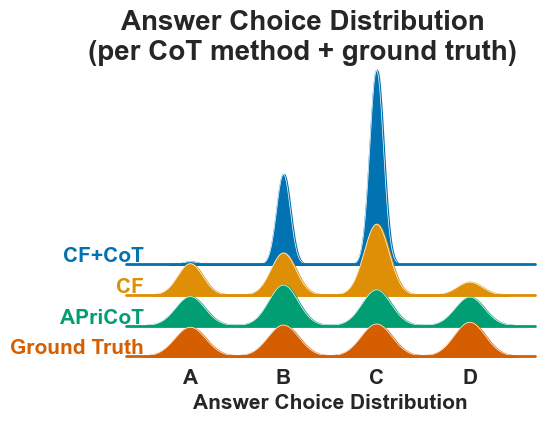

In [11]:
ridge_plot_ans_dist()

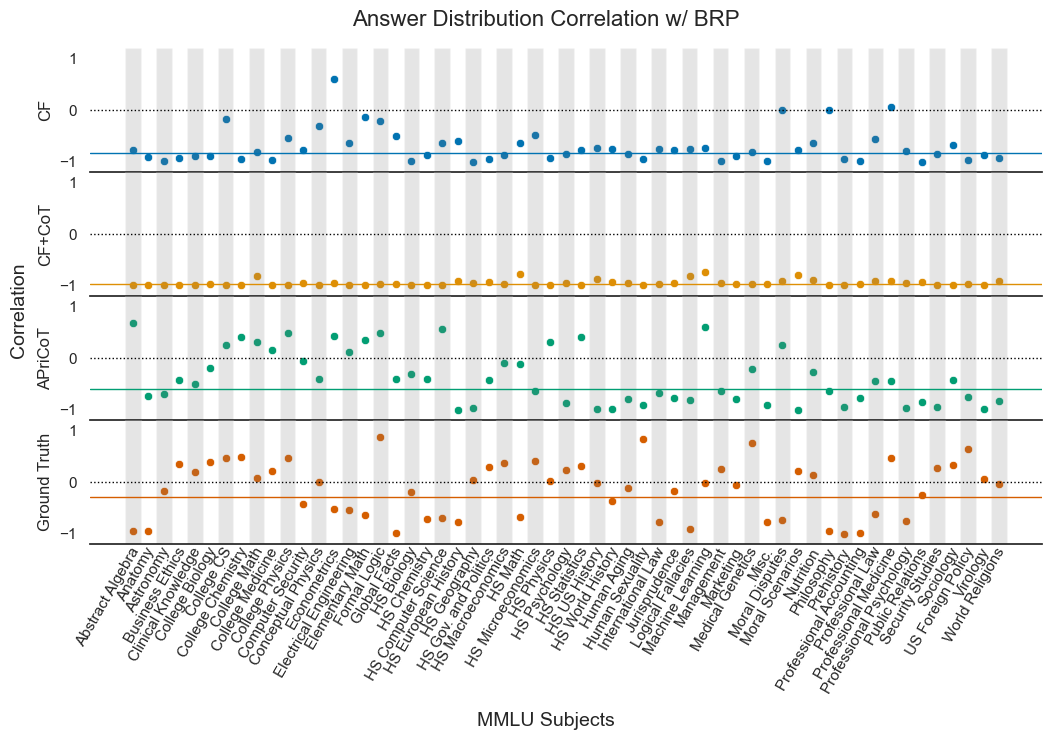

In [16]:
br_dist_corr_lines(agg_br_cloze, spearman=False, total_line=True, fishersz=True)

## Answer change analysis: CF -> CF+CoT and CF -> APriCoT

In [17]:
def change_confusion_matrix(results_dict_1, results_dict_2):
    conf_mat = [
        [0, 0],
        [0, 0]
    ]

    for sub in results_dict_1.keys():
        if sub == 'base_rate':
            continue
        for ques_num in results_dict_1[sub].keys():
            corr = results_dict_1[sub][ques_num]['correct_answer']
            pred_1 = get_pred(results_dict_1[sub][ques_num])
            pred_2 = get_pred(results_dict_2[sub][ques_num])

            row = int(pred_1 == corr)
            col = int(pred_2 == corr)
            conf_mat[row][col] += 1
    
    return conf_mat

In [18]:
def answer_shift_heatmaps():
    unprimed = change_confusion_matrix(no_cot_res, unprimed_res)
    primed = change_confusion_matrix(no_cot_res,   primed_res)

    vmin = min(np.min(unprimed),np.min(primed))
    vmax = max(np.max(unprimed),np.max(primed))

    cmap = "flare"
    annot_kw = {
        'fontsize' : 'xx-large',
        'fontweight' : 'heavy'
    }

    fig, (ax1, ax2) = plt.subplots(1, 2)

    sns.heatmap(unprimed,
                vmin=vmin,
                vmax=vmax,
                cmap=cmap,
                annot=True,
                fmt='',
                annot_kws=annot_kw,
                cbar=False,
                square=True,
                ax=ax1,
                xticklabels=['Incorrect', 'Correct'],
                yticklabels=['Incorrect', 'Correct'])
    sns.heatmap(primed,
                vmin=vmin,
                vmax=vmax,
                cmap=cmap,
                annot=True,
                fmt='',
                annot_kws=annot_kw,
                cbar=False,
                square=True,
                ax=ax2,
                yticklabels=False,
                xticklabels=['Incorrect', 'Correct'])

    ax1.set_xlabel('Unprimed CoT')
    ax2.set_xlabel('APriCoT')

    fig.supylabel('No CoT')


    fig.tight_layout()

    plt.show()



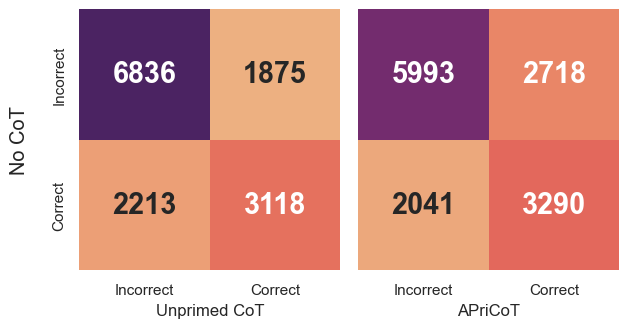

In [19]:
answer_shift_heatmaps()

### Sankey Diagram
Numbers obtained from heatmaps above.

Sankey generated using [SankeyMatic](https://www.sankeymatic.com/) using config defined in ./sankey_config.txt. Further aesthetic edits made using [paint.net image editor](https://www.getpaint.net/download.html)

<img src="./sankey.png" width=800/>